In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import sqlite3  # SQL integration
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [4]:
# Basic statistics about the dataset
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [5]:
# Good No Null Values!
df.isnull().sum().max()

0

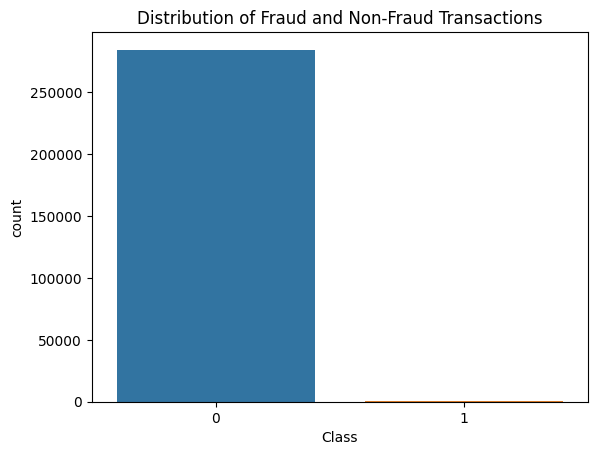

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


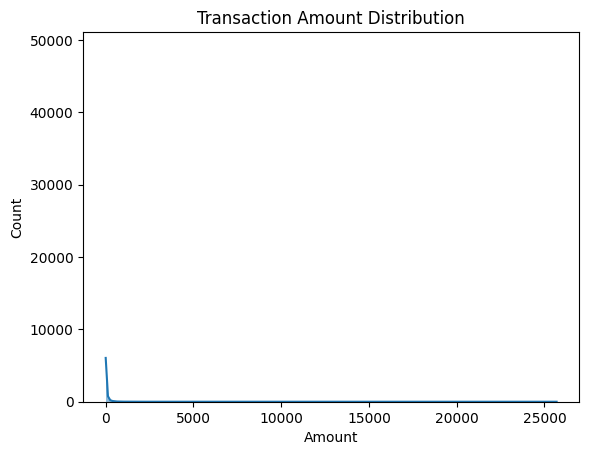

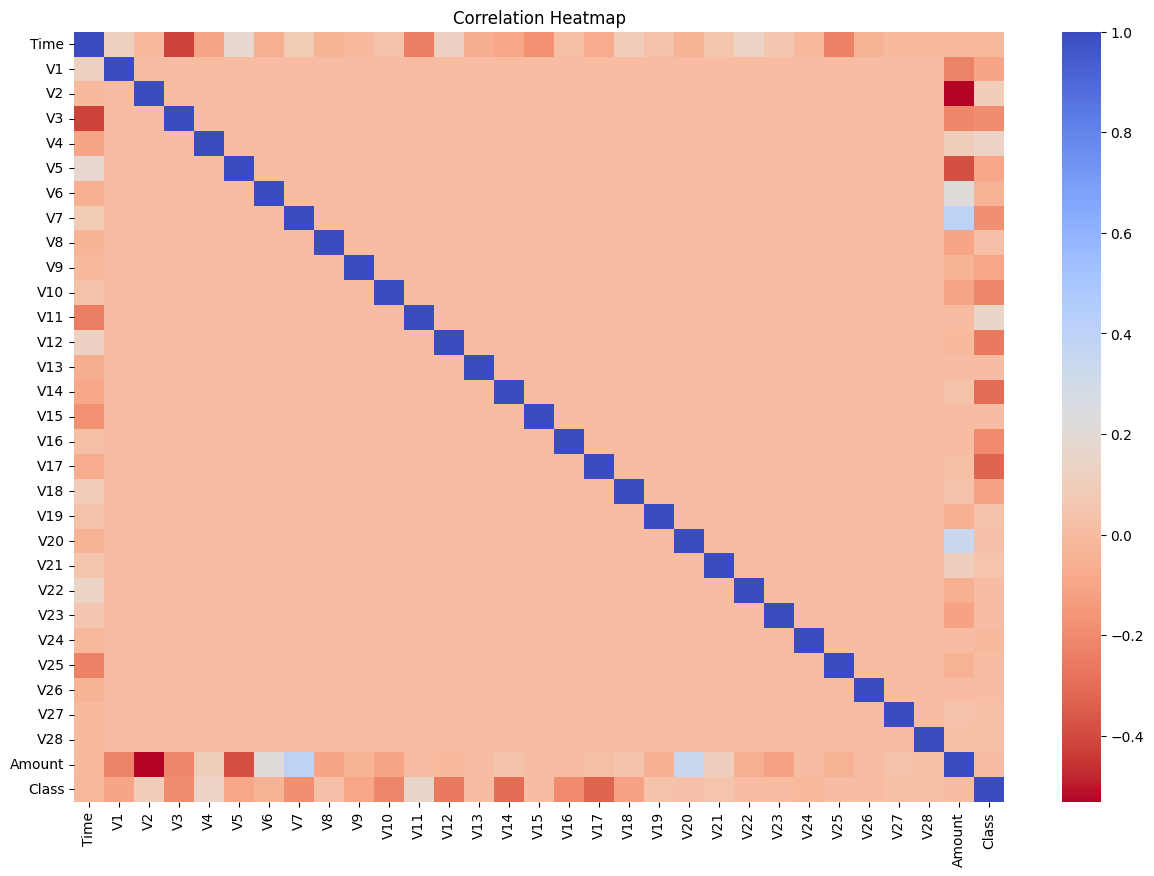

In [6]:
# Distribution of 'Class' (0: Non-Fraud, 1: Fraud)
sns.countplot(x='Class', data=df)
plt.title('Distribution of Fraud and Non-Fraud Transactions')
plt.show()

# Visualizing Amount distributions
sns.histplot(df['Amount'], kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

# Correlation heatmap to visualize PCA-transformed features
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), cmap='coolwarm_r')
plt.title('Correlation Heatmap')
plt.show()

In [7]:
# Creating time-based features
df['Hour'] = df['Time'] // 3600  # Converting seconds to hours
df['Day'] = df['Time'] // (3600 * 24)  # Converting seconds to days

# Drop the 'Time' column after creating these features
df = df.drop(columns=['Time'])

# Feature scaling (for 'Amount')
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(columns=['Amount'])


In [8]:
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V23       V24       V25       V26  \
0  0.098698  0.363787  0.090794  ... -0.110474  0.066928  0.128539 -0.189115   
1  0.085102 -0.255425 -0.166974  ...  0.101288 -0.339846  0.167170  0.125895   
2  0.247676 -1.514654  0.207643  ...  0.909412 -0.689281 -0.327642 -0.139097   
3  0.377436 -1.387024 -0.054952  ... -0.190321 -1.175575  0.647376 -0.221929   
4 -0.270533  0.817739  0.753074  ... -0.137458  0.141267 -0.206010  0.502292   

        V27       V28  Class  Hour  Day  Amount_scaled  
0  0.133558 -0.021053      0   0.0  0.0       0.244964  
1 -0.008983  0.014724      0   0.0  0.0      -0.342475  
2 -0.055353 -0.059752      0   0.0  0.0       1.160686  
3  0.062723  0.061458      0   0.0  0.0       0.140534  
4  0.219422  0.215153      0   0.0  0.0      -0.073403  

[5 rows x 32 columns]

In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy Score:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.64      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score: 0.9991573329588147


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score: 0.9995962220427653


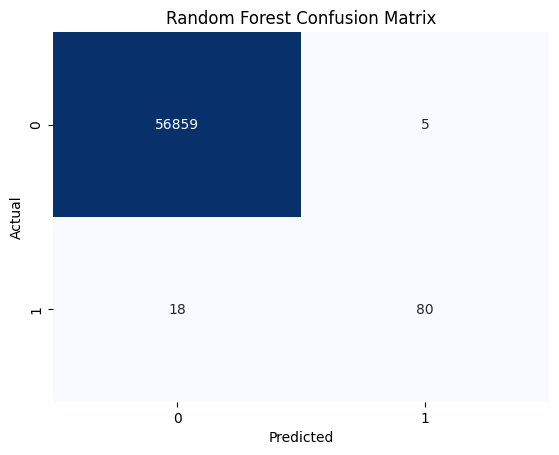

In [11]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
# Connecting to SQLite
conn = sqlite3.connect('credit_card_fraud.db')
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Sample SQL Query: Retrieving high-value transactions
query = "SELECT * FROM transactions WHERE Amount_scaled > 2.0"
high_value_transactions = pd.read_sql(query, conn)
print(high_value_transactions.head())


         V1         V2        V3        V4        V5        V6        V7  \
0 -1.004929  -0.985978 -0.038039  3.710061 -6.631951  5.122103  4.371691   
1 -0.773293  -4.146007 -0.932038  0.027094 -1.698307  0.460188  0.737344   
2 -5.101877   1.897022 -3.458034 -1.277543 -5.517758  2.098366  3.329603   
3 -1.640014  -0.479831  1.613630  2.997979 -3.803788  5.051812  3.315254   
4 -6.093248 -12.114213 -5.694973  3.294389 -1.413792  4.776000  4.808426   

         V8        V9       V10  ...       V23       V24       V25       V26  \
0 -2.006868 -0.278736 -0.230873  ...  0.969719  0.019445  0.570923  0.333278   
1 -0.314216 -0.842673  0.017276  ... -1.134769 -0.654958  0.098386 -0.209150   
2  1.250966  0.271501 -0.305483  ... -0.555900 -0.761660  0.066611  0.767227   
3 -0.303785  0.671395  0.744104  ... -0.405779 -1.268700  0.494090  0.610967   
4 -0.228197 -0.525896 -1.724899  ... -3.553381  1.215279 -0.406073 -0.653384   

        V27       V28  Class  Hour  Day  Amount_scaled  
0  0.

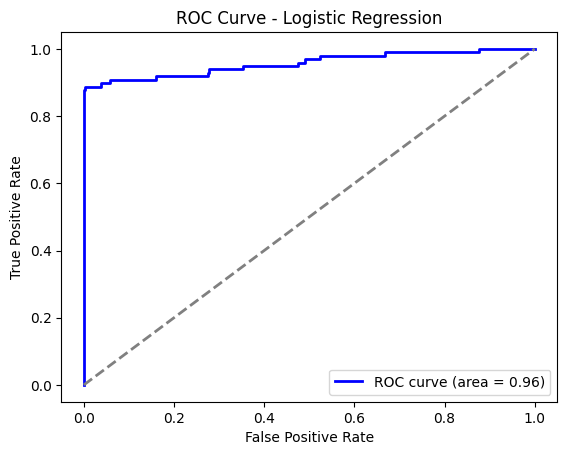

In [13]:
# ROC-AUC Curve (Logistic Regression)
from sklearn.metrics import roc_curve, auc

y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


In [14]:
# Bar chart for fraud vs non-fraud
fraud_vs_nonfraud = df['Class'].value_counts().reset_index()
fraud_vs_nonfraud.columns = ['Class', 'Count']

fig = px.bar(fraud_vs_nonfraud, x='Class', y='Count', title="Fraud vs Non-Fraud Transactions",
             labels={'Class': 'Transaction Type', 'Count': 'Number of Transactions'})
fig.show()

# Scatter plot for transaction amount vs time, colored by fraud or non-fraud
fig = px.scatter(df, x='Hour', y='Amount_scaled', color='Class', 
                 title='Transaction Amount vs Time (Fraud vs Non-Fraud)',
                 labels={'Amount_scaled': 'Scaled Amount', 'Hour': 'Time in Hours'})
fig.show()

# ROC Curve using Plotly
from sklearn.metrics import roc_curve, auc

y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = %0.2f)' % roc_auc))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))
fig.update_layout(title='ROC Curve - Logistic Regression',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()


***Method 1:***

**Logistic Regression**

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, f1_score

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

# Confusion Matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix_lr)

# ROC AUC Score
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
print("ROC AUC Score:", roc_auc_lr)

# Average Precision Score
avg_precision_lr = average_precision_score(y_test, y_pred_prob_lr)
print("Average Precision Score:", avg_precision_lr)

# F1 Score
f1_lr = f1_score(y_test, y_pred_lr)
print("F1 Score:", f1_lr)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962

Confusion Matrix:
[[56851    13]
 [   35    63]]
ROC AUC Score: 0.9569630152286013
Average Precision Score: 0.7422693870149892
F1 Score: 0.7241379310344829


**Random Forest**

In [16]:
# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

# ROC AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print("ROC AUC Score:", roc_auc_rf)

# Average Precision Score
avg_precision_rf = average_precision_score(y_test, y_pred_prob_rf)
print("Average Precision Score:", avg_precision_rf)

# F1 Score
f1_rf = f1_score(y_test, y_pred_rf)
print("F1 Score:", f1_rf)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9412    0.8163    0.8743        98

    accuracy                         0.9996     56962
   macro avg     0.9704    0.9081    0.9371     56962
weighted avg     0.9996    0.9996    0.9996     56962

Confusion Matrix:
[[56859     5]
 [   18    80]]
ROC AUC Score: 0.9577906253947837
Average Precision Score: 0.8697791656358487
F1 Score: 0.8743169398907105


**Visualize Confusion matrix**

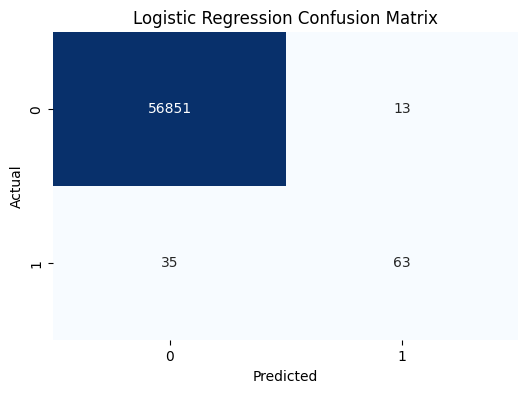

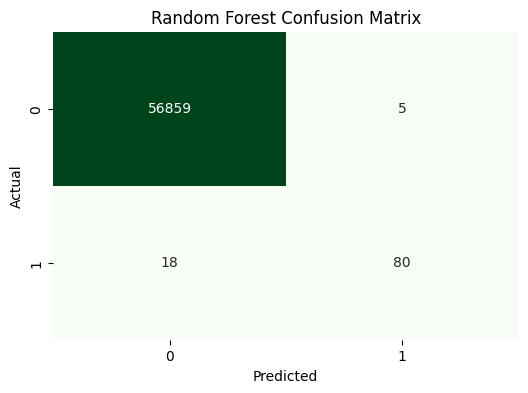

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Plot ROC Curves**

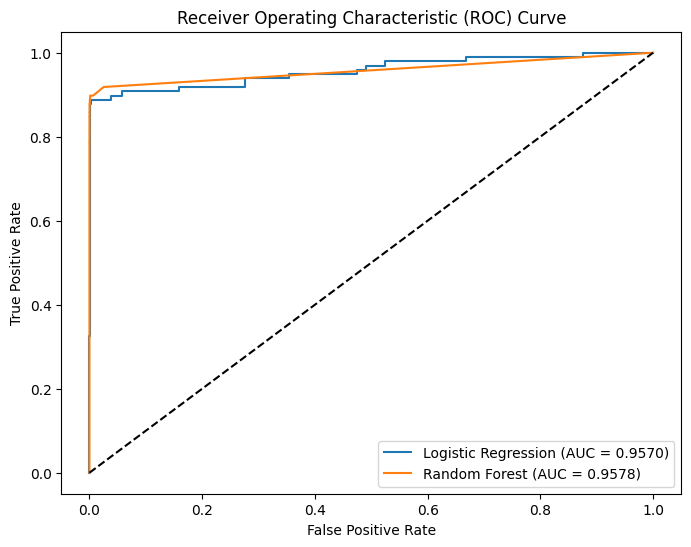

In [18]:
from sklearn.metrics import roc_curve, auc

# ROC Curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.4f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.4f)' % roc_auc_rf)
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Plot Precision-Recalls Curves**

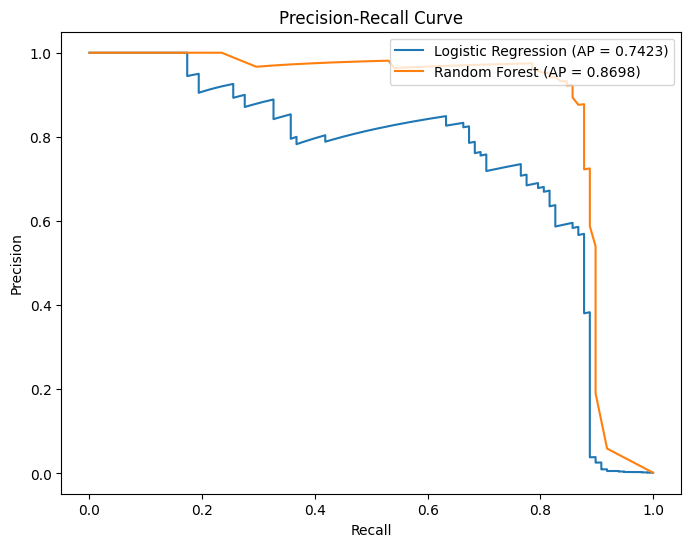

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve for Logistic Regression
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_prob_lr)
avg_precision_lr = average_precision_score(y_test, y_pred_prob_lr)

# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_prob_rf)
avg_precision_rf = average_precision_score(y_test, y_pred_prob_rf)

# Plotting
plt.figure(figsize=(8,6))
plt.plot(recall_lr, precision_lr, label='Logistic Regression (AP = %0.4f)' % avg_precision_lr)
plt.plot(recall_rf, precision_rf, label='Random Forest (AP = %0.4f)' % avg_precision_rf)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


**Feature Importance (Random Forest)**

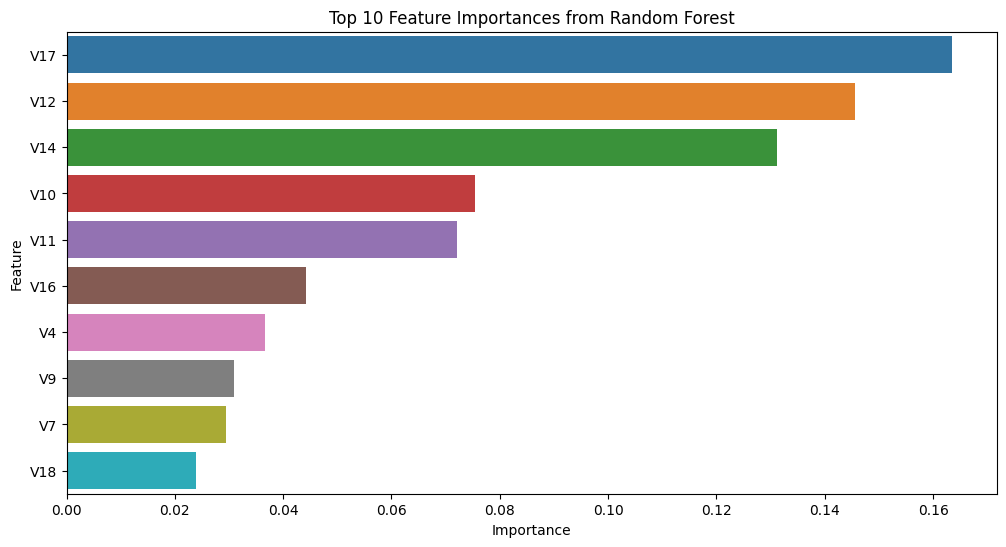

In [20]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances from Random Forest')
plt.show()


**Comparison Table**

In [21]:
# Collect metrics in a DataFrame
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf)],
    'ROC AUC': [roc_auc_lr, roc_auc_rf],
    'Average Precision': [avg_precision_lr, avg_precision_rf],
    'F1 Score': [f1_lr, f1_rf]
})

metrics = metrics.set_index('Model')
print(metrics)


                     Accuracy   ROC AUC  Average Precision  F1 Score
Model                                                               
Logistic Regression  0.999157  0.956963           0.742269  0.724138
Random Forest        0.999596  0.957791           0.869779  0.874317


**Distribution of Predicted Probabilities**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



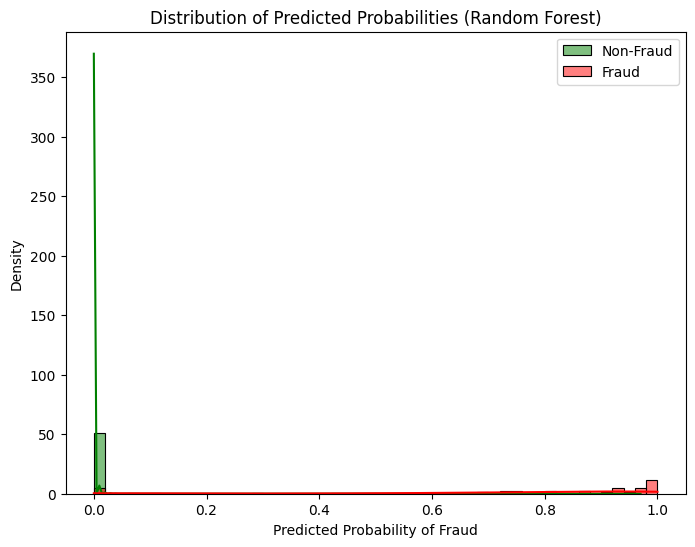

In [22]:
plt.figure(figsize=(8,6))
sns.histplot(y_pred_prob_rf[y_test == 0], color='green', label='Non-Fraud', stat='density', bins=50, kde=True)
sns.histplot(y_pred_prob_rf[y_test == 1], color='red', label='Fraud', stat='density', bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities (Random Forest)')
plt.xlabel('Predicted Probability of Fraud')
plt.legend()
plt.show()


**Use T-SNE to visualize high-dimensional data in 2D space.**

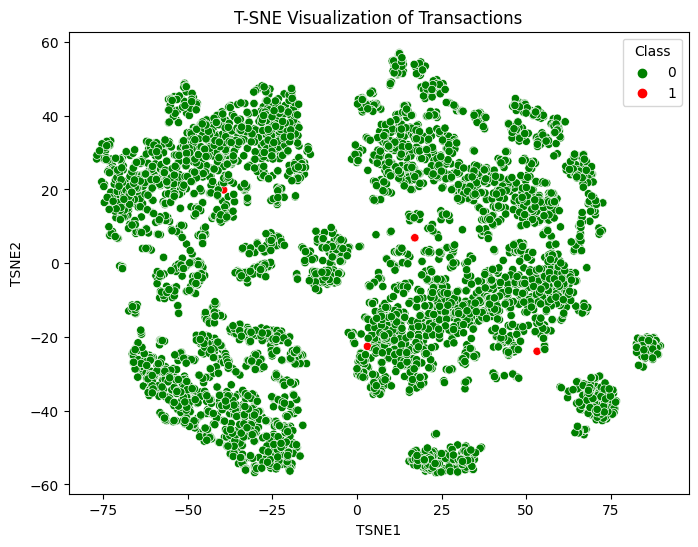

In [23]:
from sklearn.manifold import TSNE

# Sample data to reduce computation time
df_sample = df.sample(n=5000, random_state=42)
X_sample = df_sample.drop('Class', axis=1)
y_sample = df_sample['Class']

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Create a DataFrame
df_tsne = pd.DataFrame({'TSNE1': X_tsne[:,0], 'TSNE2': X_tsne[:,1], 'Class': y_sample})

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Class', data=df_tsne, palette=['green', 'red'])
plt.title('T-SNE Visualization of Transactions')
plt.show()


**Handling Imbalanced Data
The dataset is highly imbalanced, which can affect model performance.

Resampling Techniques
Using SMOTE (Synthetic Minority Over-sampling Technique):**

In [24]:
from imblearn.over_sampling import SMOTE

# Install imbalanced-learn if necessary
# !pip install imbalanced-learn

# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train Random Forest on resampled data
rf_model_res = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_res.fit(X_train_res, y_train_res)

# Predictions and Evaluation
y_pred_rf_res = rf_model_res.predict(X_test)
y_pred_prob_rf_res = rf_model_res.predict_proba(X_test)[:,1]

print("Random Forest with SMOTE Classification Report:")
print(classification_report(y_test, y_pred_rf_res, digits=4))

# Update metrics table
roc_auc_rf_res = roc_auc_score(y_test, y_pred_prob_rf_res)
avg_precision_rf_res = average_precision_score(y_test, y_pred_prob_rf_res)
f1_rf_res = f1_score(y_test, y_pred_rf_res)

# Add to metrics DataFrame
metrics.loc['Random Forest (SMOTE)'] = [accuracy_score(y_test, y_pred_rf_res), roc_auc_rf_res, avg_precision_rf_res, f1_rf_res]

print(metrics)


Random Forest with SMOTE Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8478    0.7959    0.8211        98

    accuracy                         0.9994     56962
   macro avg     0.9237    0.8978    0.9104     56962
weighted avg     0.9994    0.9994    0.9994     56962

                       Accuracy   ROC AUC  Average Precision  F1 Score
Model                                                                 
Logistic Regression    0.999157  0.956963           0.742269  0.724138
Random Forest          0.999596  0.957791           0.869779  0.874317
Random Forest (SMOTE)  0.999403  0.968828           0.871656  0.821053


**Method 2:**

**Step 1: Add Evaluation Metrics**

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

**Evaluation Function:
This function will print the metrics and plot the confusion matrix for any model.**

In [26]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Score
    print("ROC-AUC Score:", roc_auc_score(y_true, y_pred))


**Step 2: Evaluate Logistic Regression Model**

Model: Logistic Regression
Accuracy: 0.9991573329588147
Precision: 0.8289473684210527
Recall: 0.6428571428571429
F1-Score: 0.7241379310344829


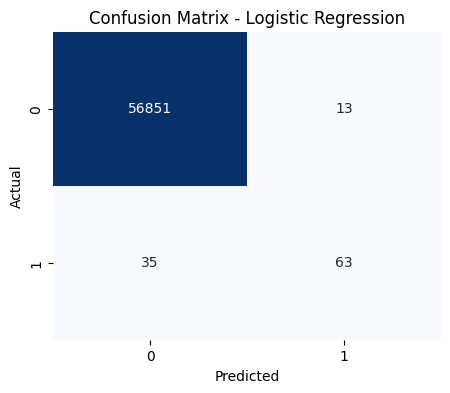

ROC-AUC Score: 0.8213142636063991


In [27]:
# Evaluate Logistic Regression
y_pred_lr = lr_model.predict(X_test)
evaluate_model(y_test, y_pred_lr, "Logistic Regression")


**Step 3: Evaluate Random Forest Model**

Model: Random Forest
Accuracy: 0.9995962220427653
Precision: 0.9411764705882353
Recall: 0.8163265306122449
F1-Score: 0.8743169398907105


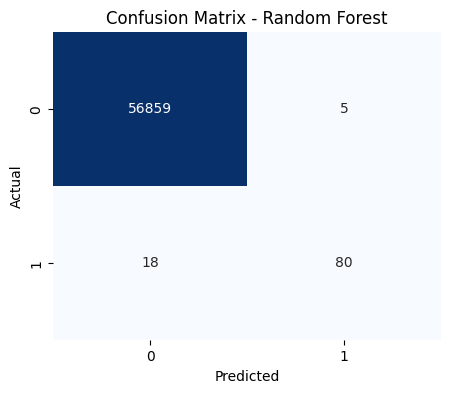

ROC-AUC Score: 0.9081193007591333


In [28]:
# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
evaluate_model(y_test, y_pred_rf, "Random Forest")


**Step 4: ROC-AUC Curve Visualization
The ROC-AUC curve is a great way to visually compare how well each model performs in terms of distinguishing between fraud and non-fraud transactions. Here's how to plot it for both models.**

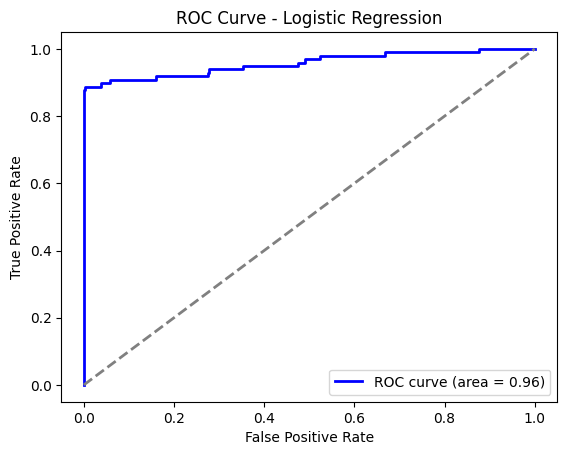

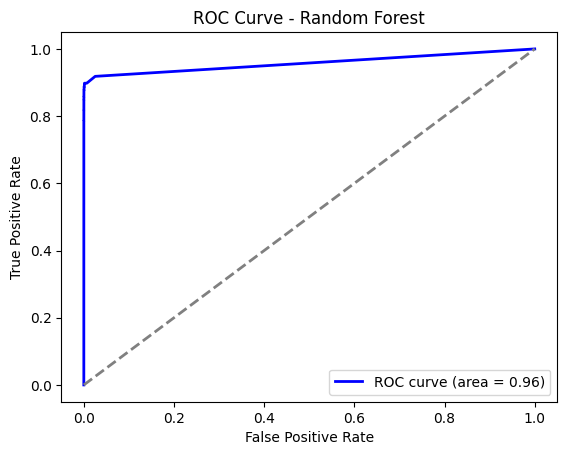

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC-AUC for Logistic Regression
plot_roc_curve(lr_model, X_test, y_test, "Logistic Regression")

# Plot ROC-AUC for Random Forest
plot_roc_curve(rf_model, X_test, y_test, "Random Forest")


**Step 5: Feature Importance Visualization (For Random Forest)
To understand which features have the most influence on the model, you can visualize feature importance in the Random Forest model.**

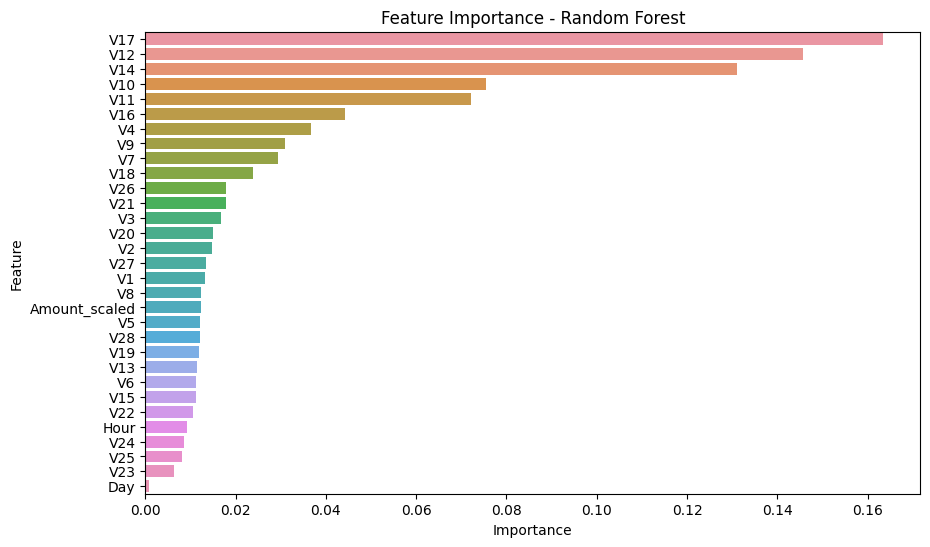

In [30]:
# Feature importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title('Feature Importance - Random Forest')
plt.show()


**Step 6: Precision-Recall Curve Visualization (Optional)
For an imbalanced dataset like fraud detection, you can also visualize the Precision-Recall Curve to get a better sense of model performance in classifying the minority class (fraudulent transactions).**

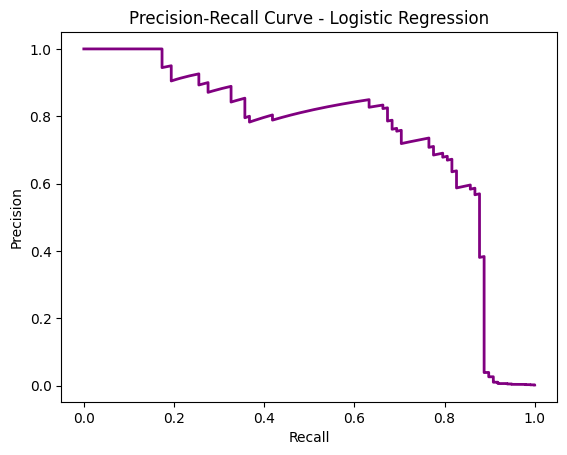

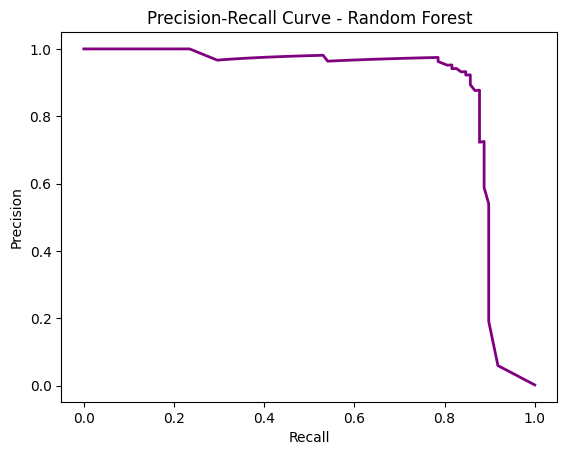

In [31]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    
    plt.figure()
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()

# Plot Precision-Recall Curve for Logistic Regression
plot_precision_recall_curve(lr_model, X_test, y_test, "Logistic Regression")

# Plot Precision-Recall Curve for Random Forest
plot_precision_recall_curve(rf_model, X_test, y_test, "Random Forest")
